# Goal

In this notebook we develop and save out the emulator for future sea level rise under forcing from a high emissions (RCP8.5) climate scenario. The saved emulator will be sampled (in **sample_rcp_emulator.ipynb**) using the prior parameter values found with LIG constraints in in **sample_lig_emulator.ipynb**.

The steps in this code are:

    1. Load in the RCP8.5 simulations
    2. Structure the Data for Emulation
        a. Normalize the axes
        b. Create a parameter grid mesh
    3. Define the emulator structure and Train/condition on the data
    4. Visualize the Model Mean and Variance
    5. Save the emulator

# Setup

In [1]:
# import the relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
# define colormap
plt.set_cmap('viridis')
from lig_utilities import draw_straight_line
# define the save path for our plots
save_path='./figures/'
# set the default grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

<Figure size 432x288 with 0 Axes>

In [3]:
# import the GPflow package for GP regression
import gpflow
from lig_utilities import normalize, denormalize, archive_gpflow_model
from datetime import datetime
# import tensorflow so we can save the trained model
import tensorflow as tf

# Load Data and Subset

In [4]:
# define the data location
rcp_path='./data/rcp85_data_sept18.pk1'
# load dictionary containing the data
rcp_data=pickle.load( open( rcp_path, "rb" ) )
# define parameter value grids
crevliq=rcp_data['crevliq']
clifvmax=rcp_data['clifvmax']

Emulation time increases dramatically with the number of training points, $\mathcal{O}(n^3)$, so we limit the inputs by training on ten-year averages for analysis. We take the averages and subset the data accordingly.

We are interested in constructing our emulator starting in 1990 and through 2200, so we reduce the timeseries range to focus on that period. We will subset results through 2150 for analysis, to avoid endpoint biases near 2200.

In [5]:
# take a 10-year moving average and center on the middle year of the average
rcp_mvavg = rcp_data['tais'].rolling(window=10,center=True).mean()
rcp_vals = rcp_data['tais']
# reduce the time period to the period of interest
rcp_mvavg_2200=rcp_mvavg.head(260)
rcp_vals_2200=rcp_vals.head(260)
# take a slice every ten years, starting in 1995 (i.e. the decade's average, 1990-1999)
rcp_slice=rcp_mvavg_2200.iloc[40::10,:]
rcp_slice=rcp_vals_2200.iloc[40::10,:]
# define the time index for these
rcp_index=rcp_slice.index

In [6]:
rcp_index

Float64Index([1990.0, 2000.0, 2010.0, 2020.0, 2030.0, 2040.0, 2050.0, 2060.0,
              2070.0, 2080.0, 2090.0, 2100.0, 2110.0, 2120.0, 2130.0, 2140.0,
              2150.0, 2160.0, 2170.0, 2180.0, 2190.0, 2200.0],
             dtype='float64')

In [7]:
# Put the simulations/indices for the emulator into the right format (the training target points):
rcpY_train=np.asarray(rcp_slice,dtype='float64')
rcp_time=np.asarray(rcp_index,dtype='float64')

Set all changes in the training data (and thus the emulator) relative to the year 2000.

In [8]:
# zero out every rcp run at 2000
rcp2000_i=np.where(rcp_time==2000)
rcpY_train=np.squeeze(rcpY_train-rcpY_train[rcp2000_i,:])

### Condition Data for Emulation

In [9]:
# Normalize the length scales of the axes
CLIFVMAX_norm=normalize(clifvmax)
CREVLIQ_norm=normalize(crevliq)
TIME_norm=normalize(rcp_time)

In [10]:
# create a meshgrid of the defined parameters and time, and then reshape
xv, yv, tv = np.meshgrid(CLIFVMAX_norm, CREVLIQ_norm, TIME_norm, indexing='ij')
nx,ny,nt = len(clifvmax),len(crevliq),len(rcp_time)

# build the grid on which the data lies for emulation
X_train=np.transpose([tv,yv,xv]).reshape(nx*ny*nt,3)

# Emulation

Perform the emulation we use [GPflow](https://gpflow.readthedocs.io/en/develop/index.html), as in **construct_lig_emulator.ipynb**. We use the same covariance function, except we add a 3-dimensional time/model-parameter interaction term, and the roughness parameter of the Matern function is taken to be 5/2.

### Create a sample grid

We create a grid of parameter values which we can sample from to visualize our results. Note that because our training axes have been normalized, our samples are also drawn from a uniform distribution between 0 and 1, and then denormalized for plotting.

In [11]:
# define the grid for visualization
sample_crevliq=np.linspace(-0.1,1.1,70)
sample_clifvmax=np.linspace(-0.1,1.1,70)
sample_time=np.linspace(0,1,43)
xx, yy, tt = np.meshgrid(sample_clifvmax,sample_crevliq,sample_time, indexing='ij')
ns1,ns2,ns3 = len(sample_clifvmax),len(sample_crevliq),len(sample_time)
X_sample=np.transpose([tt,yy,xx]).reshape(ns1*ns2*ns3,3)

In [12]:
# denormalize the sample grid
denorm_x=denormalize(sample_clifvmax,np.max(clifvmax),np.min(clifvmax))
denorm_y=denormalize(sample_crevliq,np.max(crevliq),np.min(crevliq))
denorm_time=denormalize(sample_time,np.max(rcp_time),np.min(rcp_time))

### Train the Emulator: k =  Matern 5/2(CLIFVMAX,CREVLIQ) + Matern 5/2(CLIFVMAX,CREVLIQ)xMatern 5/2(TIME)

In [13]:
# create the model name
model_name='rcp_model'

In [14]:
# create an object to time the emulation
startTime = datetime.now()

# create the GP model
with gpflow.defer_build():
    
    # define a kernel and store the code for reconstruction
    k = gpflow.kernels.Matern52(2,active_dims=[0,1])*gpflow.kernels.Matern52(1,active_dims=[2])\
        +gpflow.kernels.Matern52(2,active_dims=[0,1])
    kernel_code='gpflow.kernels.Matern52(2,active_dims=[0,1])*gpflow.kernels.Matern52(1,active_dims=[2])\
        +gpflow.kernels.Matern52(2,active_dims=[0,1])'
    
    # create the model
    m = gpflow.models.GPR(X_train, rcpY_train.reshape(np.size(rcpY_train),1), kern=k, name=model_name)

# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_session = m.enquire_session()
m.compile( tf_session )

#train the model
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

# print the elapse time for the emulation
print(datetime.now() - startTime)

# archive the model (uncomment to arvchive the model)
#archive_gpflow_model(m,kernel_code,tf_session,save_dir='./archived_models/')

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -9437.265710
  Number of iterations: 85
  Number of functions evaluations: 120


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -9437.265710
  Number of iterations: 85
  Number of functions evaluations: 120


1:21:46.092984


In [15]:
# fix the noise term
m.likelihood.variance = 1e-06

We set the point-wise kernel variance (i.e. the nugget) to a very small number. The model log-likelihood is give by the "Objective function value" above.

Let's look at the table with the model properties and hyperparameters:

In [16]:
# print the relevant model parameters
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
rcp_model/kern/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.5012107704313864
rcp_model/kern/kernels/0/kernels/0/variance,Parameter,None,+ve,True,(),True,1.830591620175421
rcp_model/kern/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.4548666355127329
rcp_model/kern/kernels/0/kernels/1/variance,Parameter,None,+ve,True,(),True,1.8310064734237486
rcp_model/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,2.7567453807220614
rcp_model/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,2731.897366783309
rcp_model/likelihood/variance,Parameter,None,+ve,True,(),True,1e-06


### Visualize the Model Mean Fits at 2100 & 2150

In [29]:
# get model outputs along grid
gpr_mean,gpr_var=m.predict_y(X_sample)

# denormalize the training grid
denorm_points_t=denormalize(X_train[:,0],np.max(rcp_time),np.min(rcp_time))
denorm_points_y=denormalize(X_train[:,1],np.max(crevliq),np.min(crevliq))
denorm_points_x=denormalize(X_train[:,2],np.max(clifvmax),np.min(clifvmax))

In [30]:
# collect the index locations for specific time points
ind2100=np.where(denorm_time==2100)
ind2150=np.where(denorm_time==2150)

In [31]:
# subset the mean and variance at specific time points
sample_mean=gpr_mean.reshape(ns3,ns2,ns1)
sample_var=gpr_var.reshape(ns3,ns2,ns1)
sample_mean_2100=np.squeeze(sample_mean[ind2100,:,:])
sample_var_2100=np.squeeze(sample_var[ind2100,:,:])
sample_mean_2150=np.squeeze(sample_mean[ind2150,:,:])
sample_var_2150=np.squeeze(sample_var[ind2150,:,:])

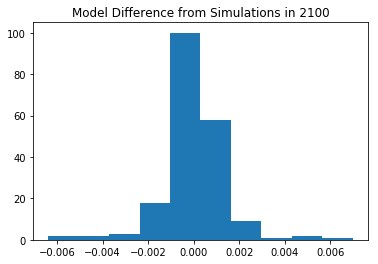

In [32]:
gpr_train_mean,gpr_train_var=m.predict_y(X_train)
check_train=gpr_train_mean.reshape(nt,ny,nx)
plt.hist(check_train[rcp_index==2100,:,:].ravel()-rcpY_train[rcp_index==2100,:].ravel())
plt.title('Model Difference from Simulations in 2100')
plt.show()

In [33]:
# build the grid on which the data lies from emulation
xv2, yv2 = np.meshgrid(clifvmax, crevliq, indexing='ij')
X_cc_plot=np.transpose([yv2,xv2]).reshape(nx*ny,2)

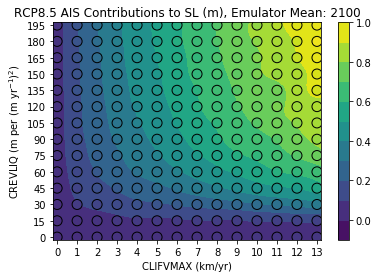

In [34]:
# plot the sample at 2100
clevels=np.linspace(-0.1,1.0,12)
gp_mean_2100_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,sample_mean_2100,clevels)
c2=plt.scatter(X_cc_plot[:,1],X_cc_plot[:,0],c=np.squeeze(rcpY_train[rcp_index==2100,:]),s=100,norm=c1.norm,edgecolors='k')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('RCP8.5 AIS Contributions to SL (m), Emulator Mean: 2100')
plt.colorbar(c1)
plt.show()

In [35]:
# save the plot out
savename='Fig2b.pdf'
gp_mean_2100_fig.savefig(save_path+savename)

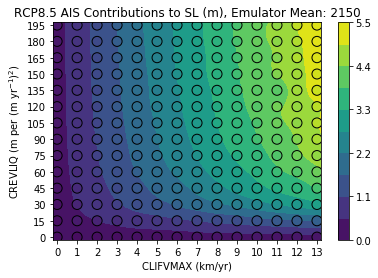

In [46]:
# plot the sample at 2150
clevels=np.linspace(0.0,5.5,11)
gp_mean_2150_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,sample_mean_2150,clevels)
c2=plt.scatter(X_cc_plot[:,1],X_cc_plot[:,0],c=np.squeeze(rcpY_train[rcp_index==2150,:]),s=100,norm=c1.norm,edgecolors='k')
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('RCP8.5 AIS Contributions to SL (m), Emulator Mean: 2150')
plt.colorbar(c1)
plt.show()

### Plot the Variance in 2100

In [47]:
# define the levels for the plot
min_val,max_val=0,0.001
clevels=np.linspace(min_val,max_val,11)

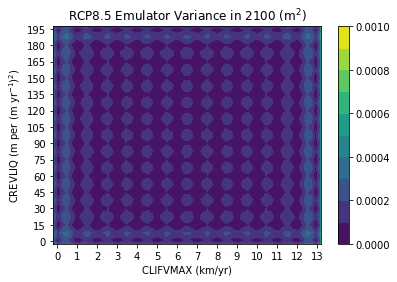

In [48]:
# plot the sample
gp_var_fig=plt.figure()
c1=plt.contourf(denorm_x,denorm_y,sample_var_2100,levels=clevels)
plt.ylim([-2.5,197.5])
plt.xlim([-0.2,13.2])
plt.xticks(clifvmax)
plt.yticks(crevliq)
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.title('RCP8.5 Emulator Variance in 2100 (m$^2$)')
plt.colorbar(c1)
plt.show()

# Save

### Save the Model

The model object is a tensorflow object, so we utilize tensorflow's built in saving method.

In [49]:
# create the saver object and archive the model object
saver = tf.train.Saver()
save_path = saver.save(tf_session, "./models/rcp_model.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ./models/rcp_model.ckpt


### Save the Data to reconstruct the model

In order to reconstruct the model in **sample_rcp_emulator.ipynb**, it is helpful to save out the training data which has already been conditioned in this code for emulation. This saves us multiple steps in the sampling code, and ensures we are using the identical data structure to restore the model.

In [50]:
# store the training data and tensorflow data
train_dat={'X_train': X_train, 'Y_train': rcpY_train, 'crevliq':crevliq, 'clifvmax': clifvmax, 'time': rcp_time, \
          'model_name': model_name, 'kernel_code': kernel_code}

# save the training data
pickle.dump(train_dat, open( "./models/rcp_model_traindata.pk1", "wb" ) )